# Plots for Hicks et al. 2019 

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pymc3 as pm
import theano as T
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os as os
import geopandas as gp
from mpl_toolkits.basemap import Basemap
import shapely
import shapefile as shp
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

import pdb

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

def spanzero(pair):
    out = True
    if all(pair<0) or all(pair>0):
        out = False
    return out

def dcize(x):
    return (x-min(x))/max(x-min(x))

def dcizeq(x,qi=75):
    uq = np.percentile(x,qi)
    x_ = x
    x_[x_>uq] = uq
    qlabels = np.round(np.percentile(x,(qi*.01,qi*.25,qi*.50,qi*.75,qi)))
    return qlabels, (x_-min(x_))/max(x_-min(x_))


def dcmax(x_,maxval):
    qi = maxval/max(x)
    x_[x_>maxval] = maxval
    qlabels = np.round(np.percentile(x_,(qi*.01,qi*.25,qi*.50,qi*.75,qi)))
    return qlabels, (x_-min(x_))/max(x_-min(x_))

def qmax(x,qi=75):
    uq = np.percentile(x,qi)
    x_ = x
    x_[x_>uq] = uq
    return x_

def qbins(x,nbins=4):
    data_percentile = x/max(x)  
    bin_edges = np.percentile(x,[(100/nbins)*r for r in range(nbins+1)])
    bins_percentile = bin_edges/max(x)
    data_binned_indices = np.digitize(data_percentile, bins_percentile, right=True)
    return np.round(np.sort(np.unique(bin_edges))), data_binned_indices

## Import data sources

In [2]:
# Nutritional data
ndata = pd.read_excel('Nutrient_data.xlsx')
# Traits data
tdata = pd.read_csv('Traits_data.csv')
# Reported species-level catch per country
sdata = pd.read_csv('Reported_unreported_EEZ.csv')
# Total catch per country
mdata = pd.read_csv('SAU_Total_EEZ.csv')
# Predicted nutrients by country
pdata = pd.read_csv('SAU_nutrient_projections_by_EEZ_reported_unreported.csv')
# SAU key
kdata = pd.read_excel('SAUkey.xlsx')

In [3]:
# Make EEZs SAU compatible
mdata.EEZ = kdata.SAUname.values[match(list(mdata.EEZ.values),list(kdata.EEZ.values))]
pdata.EEZ = kdata.SAUname.values[match(list(pdata.EEZ.values),list(kdata.EEZ.values))]

In [4]:
# Add traits information to nutritional dataframe
indx = match(ndata.Species_from_search.unique(),list(tdata.species_traits_all.values))
rindx = match(ndata.Species_from_search,list(ndata.Species_from_search.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]

In [5]:
# Add traits information to sau dataframe
indx = match(sdata.species.unique(),list(tdata.species_traits_all.values))
rindx = match(sdata.species,list(sdata.species.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    sdata[trait] = tdata[trait].values[indx][rindx]

In [6]:
# Nutrient names
Nutrients = ['Calcium', 'Iron', 'Selenium', 'Zinc', 'Vitamin A', 'Omega 3', 'Protein']
Nkeys = ['Ca_Value', 'Fe_Value', 'Se_Value', 'Zn_Value', 'VitA_Value', 'O3_Value', 'Protein_Value_perc']
nnutrients = len(Nutrients)

## Import results

In [7]:
# Model estimates
Protein = pd.read_csv('Protein_results.csv')
Zinc = pd.read_csv('Zinc_results.csv')
Iron = pd.read_csv('Iron_results.csv')
Calcium = pd.read_csv('Calcium_results.csv')
Omega3 = pd.read_csv('Omega-3_results.csv')
Vitamin_A = pd.read_csv('Vitamin_A_results.csv')
Selenium = pd.read_csv('Selenium_results.csv')

Results = [Calcium, Iron, Selenium, Zinc, Vitamin_A,  Omega3, Protein]


In [8]:
# Standardized estiamtes
Protein_std = pd.read_csv('Protein_std_results.csv')
Zinc_std = pd.read_csv('Zinc_std_results.csv')
Iron_std = pd.read_csv('Iron_std_results.csv')
Calcium_std = pd.read_csv('Calcium_std_results.csv')
Omega3_std = pd.read_csv('Omega3_std_results.csv')
Vitamin_A_std = pd.read_csv('Vitamin_A_std_results.csv')
Selenium_std = pd.read_csv('Selenium_std_results.csv')

Results_std = [Calcium_std, Iron_std, Selenium_std, Zinc_std,  Vitamin_A_std, Omega3_std,  Protein_std]

In [9]:
# Variable order
varord = ['pelagic', 'demersal',  'TL', 'MaxDepth', 'tropical', 'temperate','polar_deep', 'LMax', 'tm', 'K', 'flat', 'elongate', 'short_deep','fusiform'][::-1]

# Variable names
varnames = ['Pelagic pathway', 'Demersal pathway', 'Trophic level', 'Max depth', 'Tropical', 'Temperate', 'Cold', 'Max length', 'Maturity age', 'Growth rate', 'Flat', 'Elongate', 'Short-deep','Fusiform'][::-1]
nvar = len(varnames)

# Figure 1

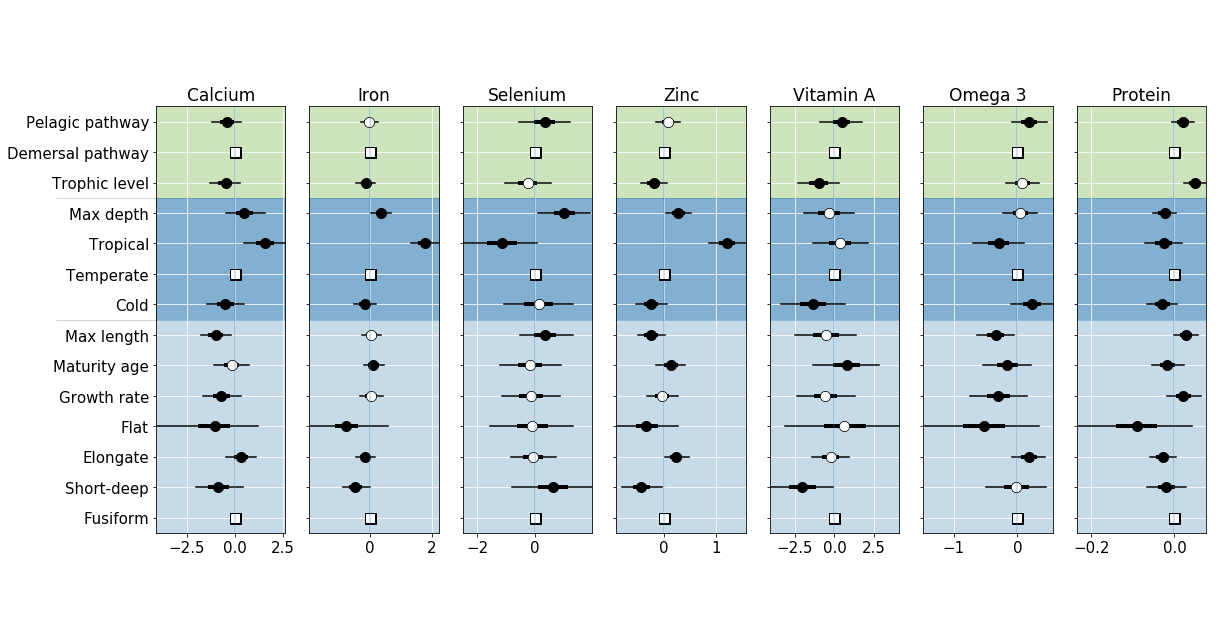

In [10]:
# Set up multipanel grid
fig = plt.figure(figsize=(17, 9),facecolor='white')
gs = mp.gridspec.GridSpec(1, 7)
ax = [fig.add_subplot(gs[0,i]) for i in range(7)]

# Asthetic controls
split1,split2,split3 = 6.5, 10.5, nvar+.5
jit = 0.1
szero = (25,75)
ymajor_ticks = np.arange(0, nvar)
yminor_ticks = (split1,split2)
xmajor_ticks = np.arange(-3, 3)
xminor_ticks = np.arange(-3, 3, 0.1)

# Loop over nutrietns
for i in range(nnutrients):
    ax_ = ax[i]
    # Plot standardized results
    resx = Results_std[i]
    rescol = list(resx.columns)
    xlimx = []
    # Loop over variables
    for j in range(nvar):
        yloc = j
        try:
            trace = resx[resx.columns[rescol.index(varord[j])]]
            mx = '.'
        except ValueError:
            pass
        else:
            if np.mean(trace)==0:
                mx = 's'
                ms = 8
            else:
                mx = '.'
                ms = 17
            x95 = np.percentile(trace,(2.5,97.5))
            xlimx += list(x95)
            ax_.plot(x95,(j,j),c='black')
            ax_.plot(np.percentile(trace,(25,75)),(j,j),c='black',linewidth=4)
            ax_.plot(np.median(trace),j, marker=mx, markersize=ms+3,c='black')
            if spanzero(np.percentile(trace,szero)):
                ax_.plot(np.median(trace), j, marker=mx, markersize=ms,c='white')
    ax_.set_title(Nutrients[i],fontsize=17)
    #ax_.set_xlim(-2,2)
    ax_.tick_params(axis='both', which='major', labelsize=15)
    ax_.set_facecolor('#E8E8EE')
    ax_.set_yticks(ymajor_ticks) 
    #ax_.set_xticks(xmajor_ticks)
    #ax_.set_xticks(xminor_ticks, minor=True)
    #ax_.grid(which='minor', alpha=0.2)
    ax_.grid(color='white')
    ax_.axvline(x=0, linestyle="-",alpha=0.3)
    ax_.fill_betweenx((split2, split3), -5, 5, color='#b2df8a', alpha=.5)
    ax_.fill_betweenx((split1, split2), -5, 5, color='#1f78b4', alpha=.5)
    ax_.fill_betweenx((-0.5, split1), -5, 5, color='#a6cee3', alpha=.5)
    ax_.set_xlim(min(xlimx),max(xlimx))
    ax_.set_ylim(-0.5,split3-1)
    if i==0:
        ax_.set_yticklabels(varnames)
        ax_.set_yticks(yminor_ticks, minor=True)
        ax_.tick_params('y', length=100, width=1, which='minor',color='lightgrey')
    else:
        ax_.set_yticklabels('')

plt.tight_layout()
plt.savefig('Figure_1.svg')


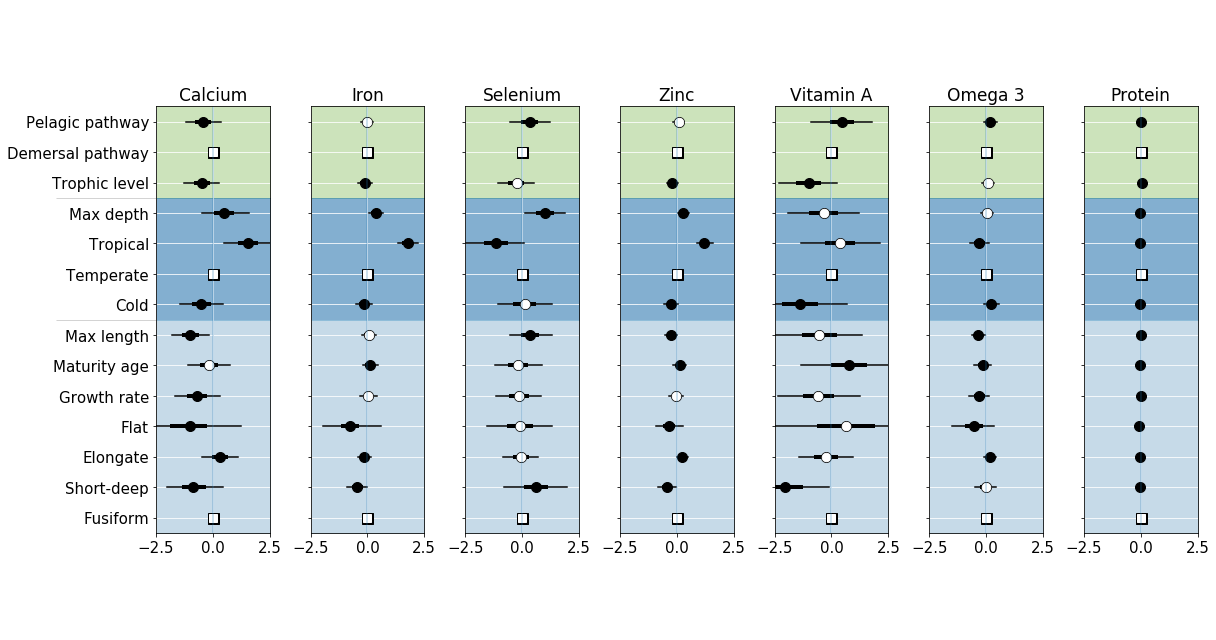

In [11]:
# Set up multipanel grid
fig = plt.figure(figsize=(17, 9),facecolor='white')
gs = mp.gridspec.GridSpec(1, 7)
ax = [fig.add_subplot(gs[0,i]) for i in range(7)]

# Asthetic controls
split1,split2,split3 = 6.5, 10.5, nvar+.5
jit = 0.1
ymajor_ticks = np.arange(0, nvar)
yminor_ticks = (split1,split2)
xmajor_ticks = np.arange(-3, 3)
xminor_ticks = np.arange(-3, 3, 0.1)

# Loop over nutrietns
for i in range(nnutrients):
    ax_ = ax[i]
    # Plot standardized results
    resx = Results_std[i]
    rescol = list(resx.columns)
    xlimx = []
    # Loop over variables
    for j in range(nvar):
        yloc = j
        try:
            trace = resx[resx.columns[rescol.index(varord[j])]]
            mx = '.'
        except ValueError:
            pass
        else:
            if np.mean(trace)==0:
                mx = 's'
                ms = 8
            else:
                mx = '.'
                ms = 17
            x95 = np.percentile(trace,(2.5,97.5))
            xlimx += list(x95)
            ax_.plot(x95,(j,j),c='black')
            ax_.plot(np.percentile(trace,(25,75)),(j,j),c='black',linewidth=4)
            ax_.plot(np.median(trace),j, marker=mx, markersize=ms+3,c='black')
            if spanzero(np.percentile(trace,szero)):
                ax_.plot(np.median(trace), j, marker=mx, markersize=ms,c='white')
    ax_.set_title(Nutrients[i],fontsize=17)
    ax_.set_xlim(-2.5,2.5)
    ax_.tick_params(axis='both', which='major', labelsize=15)
    ax_.set_facecolor('#E8E8EE')
    ax_.set_yticks(ymajor_ticks) 
    #ax_.set_xticks(xmajor_ticks)
    #ax_.set_xticks(xminor_ticks, minor=True)
    #ax_.grid(which='minor', alpha=0.2)
    ax_.grid(color='white')
    ax_.axvline(x=0, linestyle="-",alpha=0.3)
    ax_.fill_betweenx((split2, split3), -5, 5, color='#b2df8a', alpha=.5)
    ax_.fill_betweenx((split1, split2), -5, 5, color='#1f78b4', alpha=.5)
    ax_.fill_betweenx((-0.5, split1), -5, 5, color='#a6cee3', alpha=.5)
    #ax_.set_xlim(min(xlimx),max(xlimx))
    ax_.set_ylim(-0.5,split3-1)
    if i==0:
        ax_.set_yticklabels(varnames)
        ax_.set_yticks(yminor_ticks, minor=True)
        ax_.tick_params('y', length=100, width=1, which='minor',color='lightgrey')
    else:
        ax_.set_yticklabels('')

plt.tight_layout()
plt.savefig('Figure_ED1.svg')


# Figure S1

In [12]:
# Variable order
Svarord = ['whole','whole_parts','muscle', 'dry','wet', 'Expert', 'FAO','WOS', 'reef_associated', 'benthopelagic', 'pelagic_neritic', 'pelagic_oceanic', 'DemersPelag'][::-1]

# Variable names
Svarnames = ['Whole','Whole-noparts','Muscle' 'Dry', 'Wet', 'Expert', 'FAO','WoS','Reef','Benthopelagic', 'Pelagic/neritic', 'Pelagic/oceanic','Demersal/pelagic'][::-1]

Snvar = len(Svarnames)

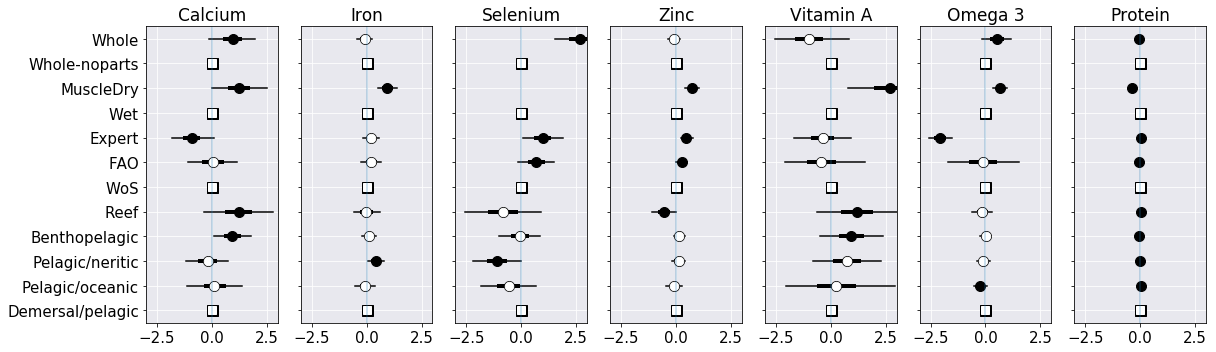

In [13]:
# Set up multipanel grid
fig = plt.figure(figsize=(17, 5),facecolor='white')
gs = mp.gridspec.GridSpec(1, 7)
ax = [fig.add_subplot(gs[0,i]) for i in range(7)]

# Asthetic controls
split3 = Snvar+.5
jit = 0.1
szero = (10,90)
ymajor_ticks = np.arange(0, Snvar)
#yminor_ticks = (split1,split2)
xmajor_ticks = np.arange(-3, 3)
xminor_ticks = np.arange(-3, 3, 0.1)

# Loop over nutrietns
for i in range(nnutrients):
    ax_ = ax[i]
    resx = Results[i]
    resx['DemersPelag']=0
    rescol = list(resx.columns)
    xlimx = []
    # Loop over variables
    for j in range(Snvar):
        yloc = j
        try:
            trace = resx[resx.columns[rescol.index(Svarord[j])]]
            mx = '.'
        except ValueError:
            pass
        else:
            if np.mean(trace)==0:
                mx = 's'
                ms = 8
            else:
                mx = '.'
                ms = 17
            x95 = np.percentile(trace,(2.5,97.5))
            xlimx += list(x95)
            ax_.plot(x95,(j,j),c='black')
            ax_.plot(np.percentile(trace,(25,75)),(j,j),c='black',linewidth=4)
            ax_.plot(np.median(trace),j, marker=mx, markersize=ms+3,c='black')
            if spanzero(np.percentile(trace,szero)):
                ax_.plot(np.median(trace), j, marker=mx, markersize=ms,c='white')
    ax_.set_title(Nutrients[i],fontsize=17)
    ax_.set_xlim(-3,3)
    ax_.tick_params(axis='both', which='major', labelsize=15)
    ax_.set_facecolor('#E8E8EE')
    ax_.set_yticks(ymajor_ticks) 
    #ax_.set_xticks(xmajor_ticks)
    #ax_.set_xticks(xminor_ticks, minor=True)
    #ax_.grid(which='minor', alpha=0.2)
    ax_.grid(color='white')
    ax_.axvline(x=0, linestyle="-",alpha=0.3)
    #ax_.set_xlim(min(xlimx),max(xlimx))
    ax_.set_ylim(-0.5,split3-1)
    if i==0:
        ax_.set_yticklabels(Svarnames)
    else:
        ax_.set_yticklabels('')

plt.tight_layout()
plt.savefig('Figure_ED2.svg')


## Calculate total nutrient yeilds per country

In [14]:
len(mdata.EEZ.unique())

280

In [15]:
# Get total catch (assumes proportionality); in kt
NCatch = mdata.groupby(['EEZ']).sum().reported_annual/1000
NCatch

EEZ
Albania                                          3.454033
Algeria                                        210.295259
American Samoa                                   7.015412
Andaman & Nicobar Isl. (India)                  70.338089
Angola                                         379.092330
Anguilla (UK)                                    0.708361
Antigua & Barbuda                                3.598066
Argentina                                      500.526374
Aruba (Netherlands)                              0.850680
Ascension Isl. (UK)                              0.033917
Australia                                       92.952754
Azores Isl. (Portugal)                          15.114793
Bahamas                                          1.251251
Bahrain                                          9.536700
Balearic Island (Spain)                          5.114085
Bangladesh                                     528.566389
Barbados                                         2.496220
Belgium   

In [16]:
len(pdata.EEZ.unique())

280

In [17]:
mdata.EEZ.values[match(list(mdata.EEZ.values),list(pdata.EEZ.values))==None]

array([], dtype=object)

In [18]:
# Nutrient concentration estimates - use minimum for NaN
Calcium_mu = (pdata.set_index('EEZ').Calcium_mu).values
Calcium_mu[np.isnan(Calcium_mu)]=np.min(Calcium_mu[np.isnan(Calcium_mu)==False])

Protein_mu = (pdata.set_index('EEZ').Protein_mu).values
Protein_mu[np.isnan(Protein_mu)]=np.min(Protein_mu[np.isnan(Protein_mu)==False])

Zinc_mu = (pdata.set_index('EEZ').Zinc_mu).values
Zinc_mu[np.isnan(Zinc_mu)]=np.min(Zinc_mu[np.isnan(Zinc_mu)==False])

Iron_mu = (pdata.set_index('EEZ').Iron_mu).values
Iron_mu[np.isnan(Iron_mu)]=np.min(Iron_mu[np.isnan(Iron_mu)==False])

Calcium_mu = (pdata.set_index('EEZ').Calcium_mu).values
Calcium_mu[np.isnan(Calcium_mu)]=np.min(Calcium_mu[np.isnan(Calcium_mu)==False])

Omega3_mu = (pdata.set_index('EEZ').Omega3_mu).values
Omega3_mu[np.isnan(Omega3_mu)]=np.min(Omega3_mu[np.isnan(Omega3_mu)==False])

Vitamin_A_mu = (pdata.set_index('EEZ').Vitamin_A_mu).values
Vitamin_A_mu[np.isnan(Vitamin_A_mu)]=np.min(Vitamin_A_mu[np.isnan(Vitamin_A_mu)==False])

Selenium_mu = (pdata.set_index('EEZ').Selenium_mu).values
Selenium_mu[np.isnan(Selenium_mu)]=np.min(Selenium_mu[np.isnan(Selenium_mu)==False])

Nutrients = ['Calcium', 'Iron', 'Selenium', 'Zinc', 'Vitamin_A', 'Omega3', 'Protein', 'Catch']

# Get EEZ order
EEZord = (pdata.set_index('EEZ').Calcium_mu).index.values

In [19]:
len(Selenium_mu)

280

In [20]:
# Order Ncatch by EEZord
NCatch = NCatch[match(list(NCatch.index.values),list(EEZord))]
NCatch

EEZ
Albania                                          3.454033
Algeria                                        210.295259
American Samoa                                   7.015412
Andaman & Nicobar Isl. (India)                  70.338089
Angola                                         379.092330
Anguilla (UK)                                    0.708361
Antigua & Barbuda                                3.598066
Argentina                                      500.526374
Aruba (Netherlands)                              0.850680
Ascension Isl. (UK)                              0.033917
Australia                                       92.952754
Azores Isl. (Portugal)                          15.114793
Bahamas                                          1.251251
Bahrain                                          9.536700
Balearic Island (Spain)                          5.114085
Bangladesh                                     528.566389
Barbados                                         2.496220
Belgium   

In [21]:
# protein (% which can be treated as g:100g); omega 3 (g/100g); vitamin A and Selenium (ug/100g); the rest are mg/100g. I think you multiplied the last lot by catch directly, but you needed to convert the concentrations to units/tonne (ie x 10,000) then multiply by the catch in tonnes. Then I think it makes sense to convert the nutrient units (g, mg, and ug) all to kg

# So multiply by 10,000
fx = 10000

# Concentraion estimates
nutrients_conc = [Calcium_mu, Iron_mu, Selenium_mu, Zinc_mu, Vitamin_A_mu, Omega3_mu, Protein_mu, NCatch]

#Units per kg
ug = 1000000000
mg = 1000000
g = 1000

# Yield estimates in kg
nutrients_y = [(Calcium_mu*fx*NCatch)/mg, (Iron_mu*fx*NCatch)/mg, (Selenium_mu*fx*NCatch)/ug, (Zinc_mu*fx*NCatch)/mg, (Vitamin_A_mu*fx*NCatch)/ug, (Omega3_mu*fx*NCatch)/g, (Protein_mu*fx*NCatch)/g, NCatch*1000]
                                         
nnutrients = len(nutrients_conc)

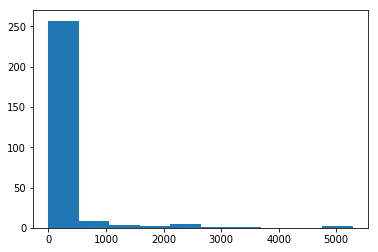

In [22]:
plt.hist(NCatch);

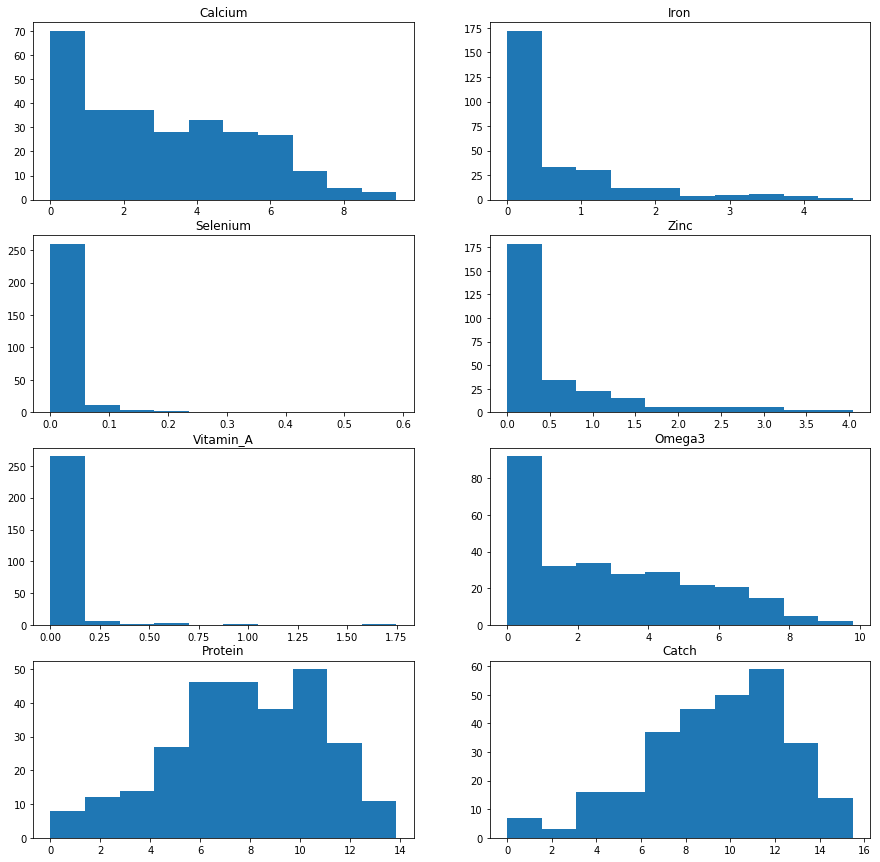

In [23]:
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

for i in range(nnutrients):
    ax_[i].hist(np.log(nutrients_y[i]+1))
    ax_[i].set_title(Nutrients[i])
    

# Figure 2

In [24]:
# Set upper limits for plotting
#ulims = [200,2,30,1.5,40,0.6,20,4000]
ulims = [250,3,30,2,50,0.6,22,4000]
# Set nutrient colours
cmlist = ['Reds', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'BuPu', 'RdPu']

# Aesthetics
def dcmax(x_,maxval):
    x_[x_>maxval] = maxval
    x = (x_-min(x_))/max(x_-min(x_))
    qlabels = np.round(np.percentile(x_,(.001,25,50,75,100)))
    return qlabels, x

In [25]:
# Sea around us polygon list
SAU = gp.GeoDataFrame.from_file('SAUEEZ_July2015.shp')
SAU.head()

,OBJECTID,EEZID,Name,Area_km2,BigMap_ID,Shape_Leng,Shape_Area,geometry
0,1,8,Albania,11104.517696,79,10.795162,1.186330,(POLYGON ((20.01002706600008 39.69120017600005...
1,2,12,Algeria,128841.900956,76,33.642817,13.077158,"POLYGON ((6.455250727000021 38.57212410500006,..."
2,3,16,American Samoa,404366.885662,164,29.825196,33.828782,"POLYGON ((-168.489166657 -11.04444465799997, -..."
3,4,24,Angola,490692.420449,73,49.007145,40.753717,(POLYGON ((12.36291108600005 -6.05293336899995...
4,5,28,Antigua & Barbuda,107937.028680,165,17.456021,9.247550,POLYGON ((-58.37216855399998 18.53182036900006...


In [26]:
len(SAU.Name.values)

280

In [27]:
# Set index for data
CmuSau = EEZord

In [28]:
CmuSau

array(['Albania', 'Algeria', 'American Samoa',
       'Andaman & Nicobar Isl. (India)', 'Angola', 'Anguilla (UK)',
       'Antigua & Barbuda', 'Argentina', 'Aruba (Netherlands)',
       'Ascension Isl. (UK)', 'Australia', 'Azores Isl. (Portugal)',
       'Bahamas', 'Bahrain', 'Balearic Island (Spain)', 'Bangladesh',
       'Barbados', 'Belgium', 'Belize', 'Benin', 'Bermuda (UK)',
       'Bonaire (Netherlands)', 'Bosnia & Herzegovina',
       'Bouvet Isl. (Norway)', 'Brazil', 'British Virgin Isl. (UK)',
       'Brunei Darussalam', 'Bulgaria', 'Cambodia', 'Cameroon',
       'Canada (Arctic)', 'Canada (East Coast)', 'Canada (Pacific)',
       'Canary Isl. (Spain)', 'Cape Verde', 'Cayman Isl. (UK)',
       'Chagos Archipelago (UK)', 'Channel Isl. (UK)', 'Chile', 'China',
       'Christmas Isl. (Australia)', 'Clipperton Isl.  (France)',
       'Cocos (Keeling) Isl. (Australia)', 'Colombia (Caribbean)',
       'Colombia (Pacific)', 'Comoros Isl.', 'Congo (ex-Zaire)',
       'Congo, R. of', '

In [29]:
CmuSau[match(list(CmuSau),list(SAU.Name.values))==None]

array([], dtype=object)

In [30]:
len('Brazil (St Paul and St. Peter Archipelago)')

42

In [31]:
# Check geospatial projection for Sea Around Us
SAU.crs

{'init': 'epsg:4326'}

In [32]:
# Create yield dataframe for plotting
new_areas_y = pd.DataFrame({'Name':CmuSau, 'Protein':nutrients_y[6], 'Zinc':nutrients_y[3], 'Iron':nutrients_y[1], 'Calcium':nutrients_y[0], 'Omega3':nutrients_y[5], 'Vitamin_A':nutrients_y[4], 'Selenium':nutrients_y[2], 'Catch':nutrients_y[7]})

# Create concentration dataframe for plotting
new_areas_c = pd.DataFrame({'Name':CmuSau, 'Protein':nutrients_conc[6], 'Zinc':nutrients_conc[3], 'Iron':nutrients_conc[1], 'Calcium':nutrients_conc[0], 'Omega3':nutrients_conc[5], 'Vitamin_A':nutrients_conc[4], 'Selenium':nutrients_conc[2], 'Catch':nutrients_conc[7]})

In [33]:
new_areas_y.to_csv('EEZ_yields.csv')
new_areas_c.to_csv('EEZ_concentrations.csv')

In [34]:
# Add data-shading info to SAU shapes
SAUEEZ_y = SAU.merge(new_areas_y, on=('Name'))
SAUEEZ_c = SAU.merge(new_areas_c, on=('Name'))

In [35]:
# Map aesthetics
water = '#dde5e8'
#e1e6e8
earth = '#efefe7'
lin = 'black'

# Linewidths
lwdx = 0.3

# Fonts
xfa = 1.3
tsize = 14*xfa
lsize = 14*xfa
asize = 14*xfa

# Re-iterate nutrient order
Nutrients = ['Calcium', 'Iron', 'Selenium', 'Zinc', 'Vitamin_A', 'Omega3', 'Protein', 'Catch']
# Re-iterate nutrient labels
Nlab = ['Calcium', 'Iron', 'Selenium', 'Zinc', 'Vitamin A', 'Omega 3', 'Protein', 'Catch']


# Concentration labels
ulxc = ['mg/100g', 'mg/100g', 'μg/100g', 'mg/100g', 'μg/100g', 'g/100g', '%', 'kt/yr' ]
# Yield labels
ulxy = ['log(kg)']*len(ulxc)

In [36]:
# Set nutrient colours
cmlist = ['Reds', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'BuPu', 'RdPu']

# Aesthetics
def dcmax(x_,maxval):
    x_[x_>maxval] = maxval
    x = (x_-min(x_))/max(x_-min(x_))
    qlabels = np.round(np.percentile(x_,(.001,25,50,75,100)))
    return qlabels, x

# Aesthetics
def dcmax2(x_):
    x = (x_-min(x_))/max(x_-min(x_))
    qlabels = np.round(np.percentile(x_,(.001,25,50,75,100)))
    return qlabels, x

In [37]:
def colourbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

In [38]:
nsaueez = len(SAUEEZ_c.geometry)

## Nutrient Map - concentrations

In [39]:
ulims = [250,3,30,2,50,0.6,22,4000]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


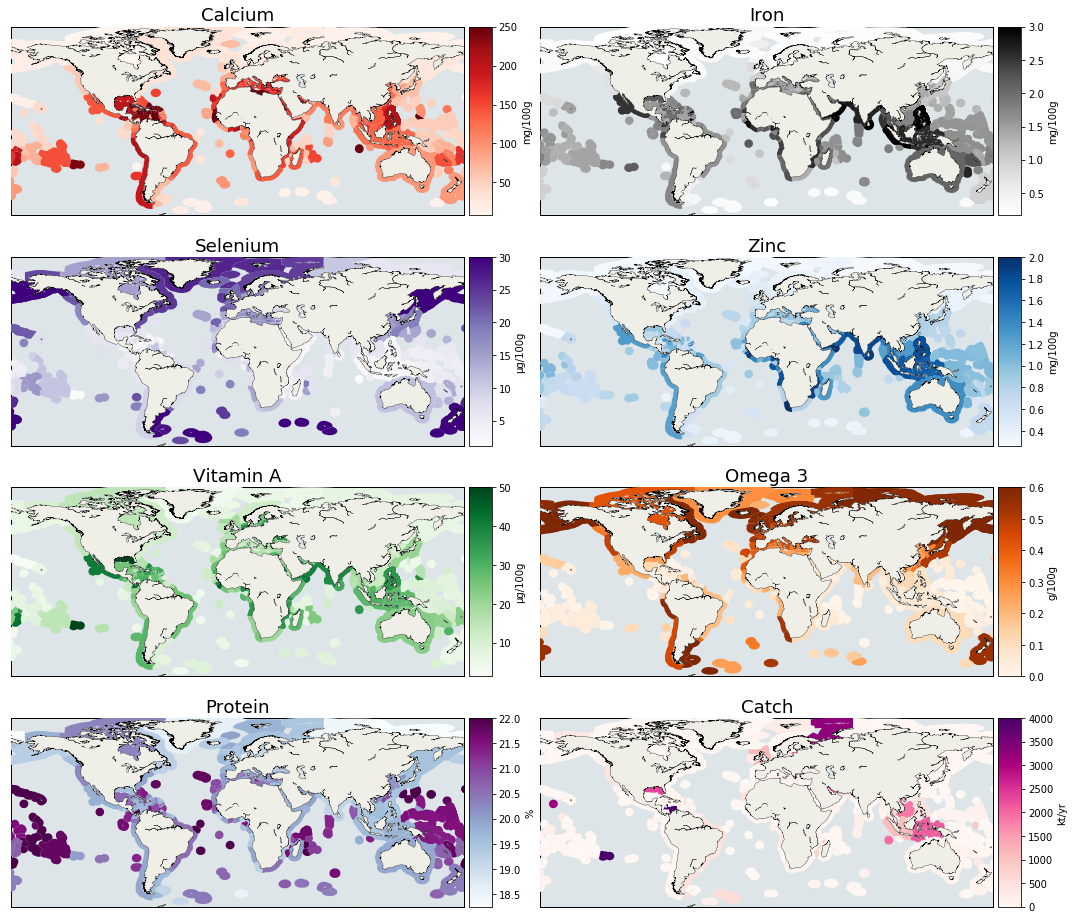

In [40]:
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

for n in range(nnutrients):
    # Grab plot frame
    ax = ax_[n]
    # Loop over nutrients
    nut = Nutrients[n]
    x = SAUEEZ_c[nut]
    # Colormap for nutrient
    cm = mp.cm.get_cmap(cmlist[n])
    qlabels,x_ = dcmax(x,ulims[n])
    cmx = cm(x_)
    # Initialize map
    mm = Basemap(resolution='l', projection='cyl', ellps='WGS84',llcrnrlon=-180,llcrnrlat=-65,urcrnrlon=180,urcrnrlat=85,lon_0=0, area_thresh=10000., ax=ax)
    bound = mm.drawmapboundary(fill_color=water,zorder=0)
    coast = mm.drawcoastlines(linewidth=lwdx,color=lin)
    continents = mm.fillcontinents(color=earth,zorder=1)

    # Iterate over EEZs
    patches = []
    COLx = []
    Xx = []
    for i in range(nsaueez):
    #for i in range(50):
        # Grab polygon
        poly = SAUEEZ_c.geometry[i]
        colx = cmx[i]
        if poly.geom_type == 'Polygon':
            mpoly = shapely.ops.transform(mm, poly)
            patches.append(PolygonPatch(mpoly))
            COLx.append(cmx[i])
            Xx.append(x.values[i])
        elif poly.geom_type == 'MultiPolygon':
            for subpoly in poly:
                mpoly = shapely.ops.transform(mm, poly)
                patches.append(PolygonPatch(mpoly))
                COLx.append(cmx[i])
                Xx.append(x.values[i])
        else:
            print(poly, " is neither a polygon nor a multi-polygon. Skipping it.")
    p = PatchCollection(patches, facecolor=cmx, linewidth=lwdx)
    ax.add_collection(p)
    ax.set_title(Nlab[n],fontsize=tsize)
    ax.tick_params(labelsize=asize)
    p.set(array=np.array(Xx),cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    cbar = fig.colorbar(p, ax=ax, label=ulxc[n], cax=cax)

# Sort out bounding box to avoid clipping
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=-13, rect=[0.01, 0.01, 1.01, 1.01])
plt.savefig('Figure_2.jpg',dpi=300)


## Nutrient Map - Yield

In [41]:
ulims_y = [7,3,.2,3,.4,8,12,14]

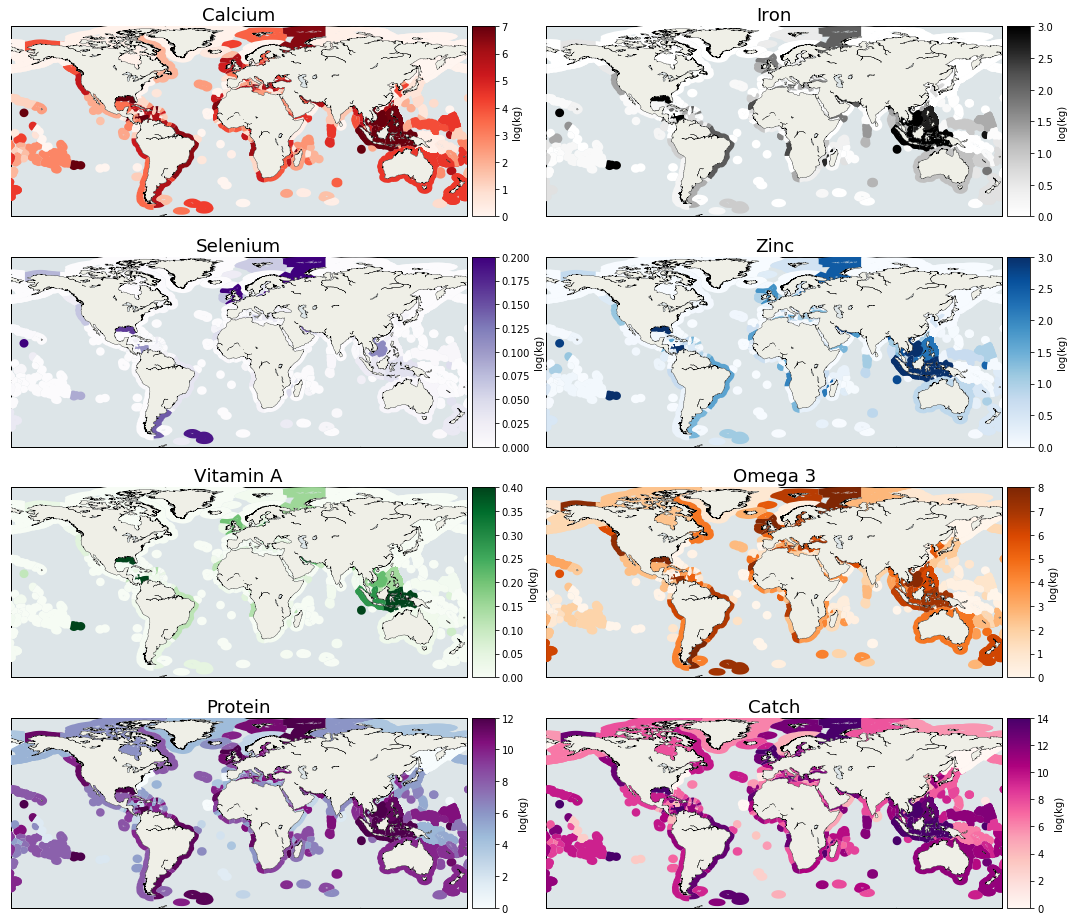

In [42]:
# Plots of yield
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

for n in range(nnutrients):
    # Grab plot frame
    ax = ax_[n]
    # Loop over nutrients
    nut = Nutrients[n]
    x = np.log(SAUEEZ_y[nut]+1)
    # Colormap for nutrient
    cm = mp.cm.get_cmap(cmlist[n])
    qlabels,x_ = dcmax(x,ulims_y[n])
    cmx = cm(x_)
    # Initialize map
    mm = Basemap(resolution='l', projection='cyl', ellps='WGS84',llcrnrlon=-180,llcrnrlat=-65,urcrnrlon=180,urcrnrlat=85,lon_0=0, area_thresh=10000., ax=ax)
    bound = mm.drawmapboundary(fill_color=water,zorder=0)
    coast = mm.drawcoastlines(linewidth=lwdx,color=lin)
    continents = mm.fillcontinents(color=earth,zorder=1)

    # Iterate over EEZs
    patches = []
    COLx = []
    Xx = []
    for i in range(nsaueez):
    #for i in range(50):
        # Grab polygon
        poly = SAUEEZ_y.geometry[i]
        colx = cmx[i]
        if poly.geom_type == 'Polygon':
            mpoly = shapely.ops.transform(mm, poly)
            patches.append(PolygonPatch(mpoly))
            COLx.append(cmx[i])
            Xx.append(x.values[i])
        elif poly.geom_type == 'MultiPolygon':
            for subpoly in poly:
                mpoly = shapely.ops.transform(mm, poly)
                patches.append(PolygonPatch(mpoly))
                COLx.append(cmx[i])
                Xx.append(x.values[i])
        else:
            print(poly, " is neither a polygon nor a multi-polygon. Skipping it.")
    p = PatchCollection(patches, facecolor=cmx, linewidth=lwdx)
    ax.add_collection(p)
    ax.set_title(Nlab[n],fontsize=tsize)
    ax.tick_params(labelsize=asize)
    p.set(array=np.array(Xx),cmap=cm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    cbar = fig.colorbar(p, ax=ax, label=ulxy[n], cax=cax)

# Sort out bounding box to avoid clipping
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=-13, rect=[0.01, 0.01, 1.01, 1.01])
plt.savefig('Figure_ED4.jpg',dpi=300)

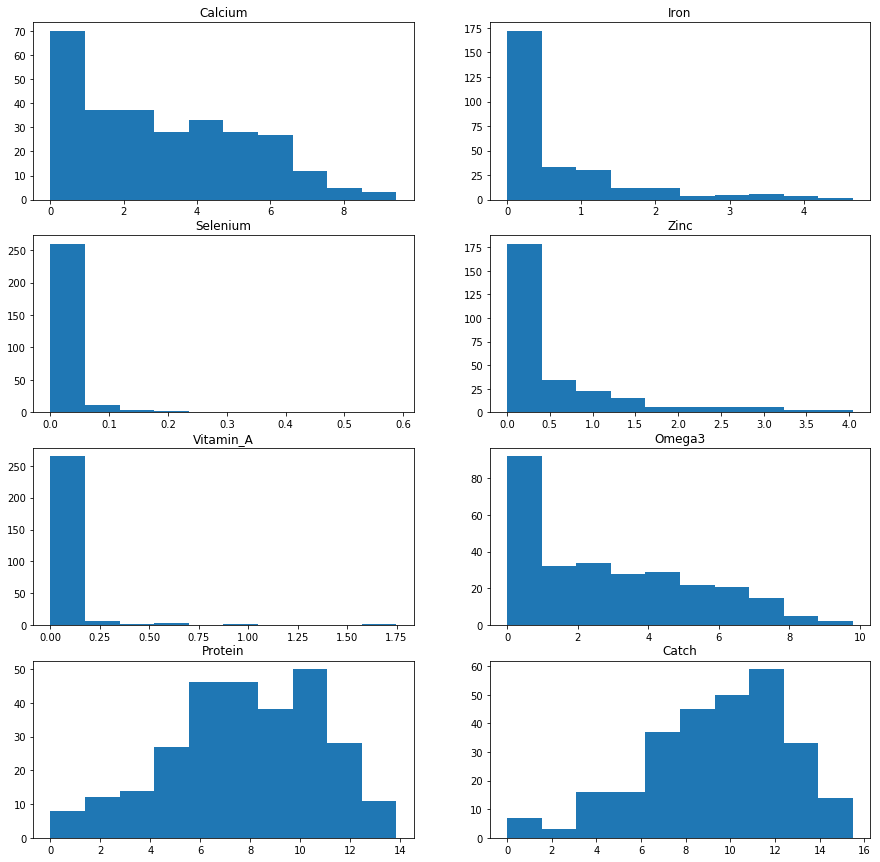

In [43]:
fig = plt.figure(figsize=(15,15))
gs = mp.gridspec.GridSpec(4, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(4) for j in range(2)]).reshape(1,8)[0]

for i in range(nnutrients):
    ax_[i].hist(np.log(nutrients_y[i]+1))
    ax_[i].set_title(Nutrients[i])
    